# Import Libraries
This section contains all the necessary imports for the project

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D, TextVectorization
from tensorflow.keras.optimizers import AdamW         # For better optimizer
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping  # For better training control
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Add

# Seed Selection

Create random seeds

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)  # Set NumPy random seed
random.seed(42)  # Set Python random seed
tf.random.set_seed(42)  # Set TensorFlow random seed

# Load Dataset
This section where we load the dataset and preview the first few rows

In [ ]:
dataset = pd.read_csv("php_vuln_CyberNative.csv", encoding="utf-8")
print(dataset.head())

# test_df = pd.read_csv("vuln_php.csv", encoding="utf-8")

  lang                                      vulnerability  system  \
0  php  Improper Input Validation and Sanitization in ...     NaN   
1  php  In PHP, an unsanitized user input could lead t...     NaN   
2  php  PHP code can have SQL injection vulnerabilitie...     NaN   
3  php  Improper sanitization of user input could lead...     NaN   
4  php  The vulnerability of SQL Injection in PHP can ...     NaN   

                                            question  \
0  Write a php code that connects to a MySQL data...   
1  Write a php code that connects to a MySQL data...   
2  Write a php code that connects to a MySQL data...   
3  Write a php code that connects to a MySQL data...   
4  Write a php code that connects to a database a...   

                                              chosen  \
0  $db = new PDO('mysql:host=localhost;dbname=tes...   
1  $host = "localhost";\n$db   = "test_db";\n$use...   
2  $host = 'localhost';\n$user = 'peter';\n$pass ...   
3  $host = "localhost";\

# Test Dataset Cleaning
Spliting the input code as functions

# Preprocessing
Perform preprocessing such as tokenization, padding, and label encoding.


In [ ]:
def create_func_target_dataframe(df):
    # Create a new DataFrame for the chosen column
    chosen_df = df[['chosen']].dropna().rename(columns={'chosen': 'func'})
    chosen_df['target'] = 0

    # Create a new DataFrame for the rejected column
    rejected_df = df[['rejected']].dropna().rename(columns={'rejected': 'func'})
    rejected_df['target'] = 1

    # Concatenate the chosen and rejected DataFrames
    result_df = pd.concat([chosen_df, rejected_df], ignore_index=True)

    return result_df

processed_df = create_func_target_dataframe(dataset)

print(processed_df)


# Check for missing values in 'func' column and fill them with a placeholder
processed_df['func'] = processed_df['func'].fillna("missing").astype(str)

# Preprocess: Replace \n with a space or remove it
processed_df['func'] = processed_df['func'].str.replace("\n", " ")  # Replace with space


# Vectorize the input
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=300, output_mode='int')
vectorizer.adapt(processed_df['func'])
X = vectorizer(processed_df['func'].values)

# ########################### CUSTOM PART ##############################
# # Vectorize the 'func' column in test_df
# X_test_df = vectorizer(test_df['func'].values)
# # Convert TensorFlow tensors to NumPy arrays for compatibility with model
# X_test_df = np.array(X_test_df, dtype='float32')


y = processed_df['target']

# Ensure no NaN values remain in the labels
if np.any(pd.isnull(y)):
    print("Error: NaN values found in labels")
    y = np.nan_to_num(y)  # Replace any unexpected NaN with zeros (if necessary)

# Convert TensorFlow tensors to NumPy arrays
X = np.array(X)
y = np.array(y)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensures balanced weighting
    classes=np.unique(y),  # Unique classes (0 and 1)
    y=y  # Training labels
)

# Convert class weights to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

                                                  func  target
0    $db = new PDO('mysql:host=localhost;dbname=tes...       0
1    $host = "localhost";\n$db   = "test_db";\n$use...       0
2    $host = 'localhost';\n$user = 'peter';\n$pass ...       0
3    $host = "localhost";\n$db   = "test_db";\n$use...       0
4    $conn = new mysqli("localhost", "username", "p...       0
..                                                 ...     ...
840  $con = mysqli_connect("localhost","username","...       1
841  $host = "localhost";\n$db   = "test_db";\n$use...       1
842  $host = "localhost";\n$db   = "test_db";\n$use...       1
843  $untrustedInput = $_GET['input'];\neval("echo ...       1
844  $db = new PDO('mysql:host=localhost;dbname=tes...       1

[845 rows x 2 columns]
Class Weights: {0: 1.0011848341232228, 1: 0.9988179669030733}


# Train/Test Split
Split the data into training and testing sets.


In [ ]:
# Split the data into training and testing sets
# Splitting the data (ensure you save indices during splitting)
X_train, X_test, y_train, y_test, func_train, func_test = train_test_split(
    X, y, processed_df['func'], test_size=0.2, random_state=42
)


# Convert data to float32 for compatibility with TensorFlow
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Check the class distribution in the training and testing sets
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Class distribution in training data:", dict(zip(unique_train, counts_train)))

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Class distribution in testing data:", dict(zip(unique_test, counts_test)))

Class distribution in training data: {0: 338, 1: 338}
Class distribution in testing data: {0: 84, 1: 85}


# Model Training
Train the CNN model on the preprocessed data.


In [ ]:
# Input layer
input_layer = Input(shape=(300,), dtype='int32')

# Embedding layer (replace with pre-trained embeddings if available)
embedding_layer = Embedding(input_dim=20001, output_dim=256, trainable=True)(input_layer)

# First Conv1D block with residual connection
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(embedding_layer)
dropout1 = Dropout(0.2)(conv1)

# Second Conv1D block
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(dropout1)
dropout2 = Dropout(0.35)(conv2)

# Global MaxPooling after both Conv1D blocks
pooled = GlobalMaxPooling1D()(dropout2)

# Fully connected layer
dense = Dense(256, activation='relu')(pooled)
dropout3 = Dropout(0.5)(dense)

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(dropout3)

# Compile model
model = Model(inputs=input_layer, outputs=output)

# Set learning rate for Adam optimizer
optimizer = Adam(learning_rate=0.0005)
# Compile the model with the custom learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Summary for debugging
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=3,                 # Stop if no improvement for 3 consecutive epochs
    restore_best_weights=True   # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=7,                         # Set a high number of epochs for tuning
    batch_size=32,
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=[early_stopping]        # Add early stopping
)



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 300, 256)            │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 300, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 300, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 300, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 300, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,334,017 (20.35 MB)

 Trainable params: 5,334,017 (20.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.4880 - loss: 0.6946 - val_accuracy: 0.7988 - val_loss: 0.6736
Epoch 2/7
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.6943 - loss: 0.6573 - val_accuracy: 0.7811 - val_loss: 0.5976
Epoch 3/7
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 0.8149 - loss: 0.5227 - val_accuracy: 0.8284 - val_loss: 0.3942
Epoch 4/7
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.8938 - loss: 0.2753 - val_accuracy: 0.9053 - val_loss: 0.2586
Epoch 5/7
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.9614 - loss: 0.1269 - val_accuracy: 0.8935 - val_loss: 0.2176
Epoch 6/7
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.9873 - loss: 0.0526 - val_accuracy: 0.8935 - val_loss: 0.2484
Epoch 7/7
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy: 0.9958 - loss: 0.0246 - val_accuracy: 0.9112 - val_loss: 0.2475


# HyperParameter Tuning

Tuning the model params


*   Best Conv1 Filters: 128
*   Best Conv1 Kernel Size: 3
*   Best Dropout1: 0.2
*   Best Conv2 Filters: 128
*   Best Conv2 Kernel Size: 5
*   Best Dropout2: 0.35
*   Best Dense Units: 256
*   Best Dropout3: 0.5
*   Best Learning Rate: 0.0005
*   Epoch: 6

In [ ]:
# # Install and Import Required Libraries
# !pip install keras-tuner
# import keras_tuner as kt
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Conv1D, Dropout, GlobalMaxPooling1D, Dense, BatchNormalization, Add
# from tensorflow.keras.optimizers import Adam
# from keras_tuner.tuners import RandomSearch

# # Function to build the model with tunable hyperparameters
# def build_model(hp):
#     input_layer = Input(shape=(300,), dtype='int32')

#     # Embedding Layer
#     embedding_layer = Embedding(input_dim=20001, output_dim=256, trainable=True)(input_layer)

#     # First Conv1D Block
#     conv1_filters = hp.Choice('conv1_filters', [64, 128, 256])  # Tunable filter size
#     conv1_kernel = hp.Choice('conv1_kernel', [3, 5, 7])  # Tunable kernel size
#     conv1 = Conv1D(filters=conv1_filters, kernel_size=conv1_kernel, activation='relu', padding='same')(embedding_layer)
#     conv1 = BatchNormalization()(conv1)
#     dropout1 = Dropout(hp.Float('dropout1', 0.2, 0.4, step=0.05))(conv1)  # Tunable dropout

#     # Second Conv1D Block
#     conv2_filters = hp.Choice('conv2_filters', [64, 128])  # Tunable filter size
#     conv2_kernel = hp.Choice('conv2_kernel', [3, 5])  # Tunable kernel size
#     conv2 = Conv1D(filters=conv2_filters, kernel_size=conv2_kernel, activation='relu', padding='same')(dropout1)
#     conv2 = BatchNormalization()(conv2)
#     dropout2 = Dropout(hp.Float('dropout2', 0.3, 0.5, step=0.05))(conv2)

#     # **Fixed Residual Connection**
#     residual = Conv1D(filters=conv2_filters, kernel_size=1, padding="same")(dropout1)
#     residual = Add()([residual, dropout2])

#     # Global Max Pooling
#     pooled = GlobalMaxPooling1D()(residual)

#     # Fully Connected Layer
#     dense_units = hp.Choice('dense_units', [64, 128, 256])  # Tunable dense units
#     dense = Dense(dense_units, activation='relu')(pooled)
#     dropout3 = Dropout(hp.Float('dropout3', 0.4, 0.6, step=0.05))(dense)  # Tunable dropout

#     # Output Layer
#     output = Dense(1, activation='sigmoid')(dropout3)

#     # Compile the Model with Tunable Learning Rate
#     learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
#     model = Model(inputs=input_layer, outputs=output)
#     model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

#     return model


# # Define the Hyperparameter Tuner
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',  # Optimize validation accuracy
#     max_trials=20,  # Increased trials for better tuning
#     executions_per_trial=1,  # Run each model once per trial
#     directory='tuner_results',  # Save results here
#     project_name='cnn_hyperparameter_tuning'
# )

# # Start Hyperparameter Search
# tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# # Get the Best Hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print the Best Tuned Hyperparameters
# print(f"Best Conv1 Filters: {best_hps.get('conv1_filters')}")
# print(f"Best Conv1 Kernel Size: {best_hps.get('conv1_kernel')}")
# print(f"Best Dropout1: {best_hps.get('dropout1')}")
# print(f"Best Conv2 Filters: {best_hps.get('conv2_filters')}")
# print(f"Best Conv2 Kernel Size: {best_hps.get('conv2_kernel')}")
# print(f"Best Dropout2: {best_hps.get('dropout2')}")
# print(f"Best Dense Units: {best_hps.get('dense_units')}")
# print(f"Best Dropout3: {best_hps.get('dropout3')}")
# print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

# Evaluation
Evaluate the model on the test set and visualize results.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8999 - loss: 0.2133
Test Loss: 0.21758626401424408
Test Accuracy: 0.8934911489486694


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
                                           func_text  Actual  \
0  $user_input = $_GET['user_input']; eval($user_...       1   
1  $servername = "localhost"; $username = "root";...       0   
2  $command = $_GET['cmd']; if(isset($command)){ ...       1   
3  $db = new PDO('mysql:host=localhost;dbname=tes...       1   
4  $db = new PDO('mysql:host=localhost;dbname=tes...       0   

   Predicted_Probability  Predicted_Class  
0               0.857281                1  
1               0.009429                0  
2               0.767980                1  
3               0.993964                1  
4               0.022290                0  


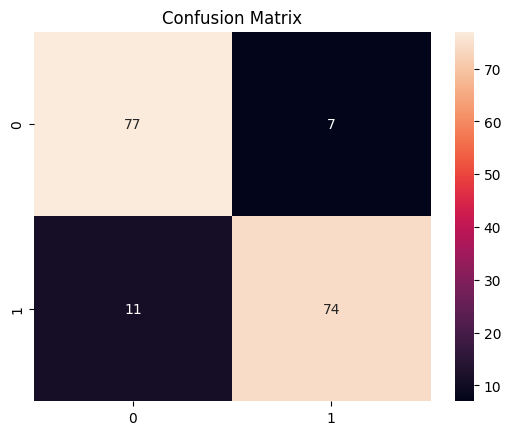

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        84
           1       0.91      0.87      0.89        85

    accuracy                           0.89       169
   macro avg       0.89      0.89      0.89       169
weighted avg       0.89      0.89      0.89       169

AUC Score: 0.8936274509803921


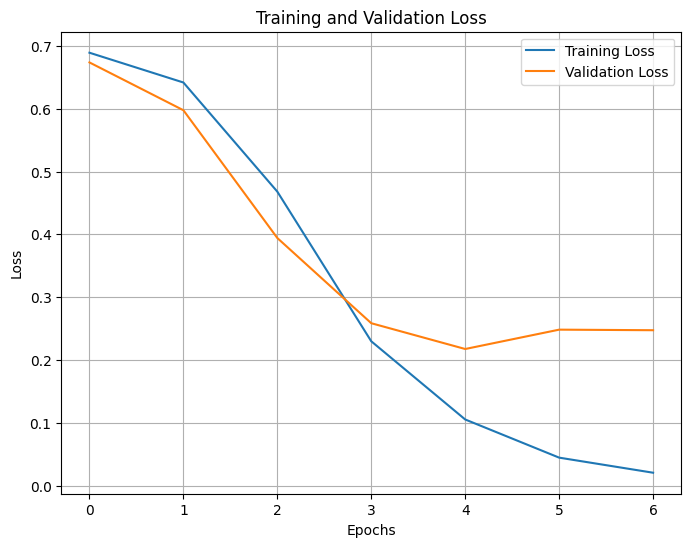

Accuracy: 89.35%
Precision: 89.44%
Recall: 89.35%
F1-score: 89.34%


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


# Make predictions on the test data
y_pred = model.predict(X_test)

# Retain the raw probabilities for now
y_pred_classes = (y_pred > 0.5).astype("int32")

# Create DataFrame with corresponding `func_text` and probabilities
results_df = pd.DataFrame({
    'func_text': func_test.reset_index(drop=True),           # The original function text (no tokenization)
    'Actual': y_test,                                        # Actual labels
    'Predicted_Probability': y_pred.flatten(),               # Raw predicted probabilities
    'Predicted_Class': y_pred_classes.flatten()              # Predicted class (0 or 1)
})

# Save results to a CSV file
results_df.to_csv('model_results.csv', index=False)

# Display the first few rows of the prediction results
print(results_df.head())

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

# AUC score
auc_acore = roc_auc_score(y_test, y_pred_classes)
print(f"AUC Score: {auc_acore}")


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

model.save("cnn_php_model.h5")

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')  # Weighted for imbalanced datasets
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")

# ########################### CUSTOM PART ############################
# # Make predictions on test_df
# y_test_pred = model.predict(X_test_df)

# # Convert probabilities to binary classes
# y_test_pred_classes = (y_test_pred > 0.5).astype("int32")

# # Create a DataFrame to visualize predictions
# results_test_df = pd.DataFrame({
#     'func_text': test_df['func'],              # Original function text
#     'Predicted_Probability': y_test_pred.flatten(),  # Raw predicted probabilities
#     'Predicted_Class': y_test_pred_classes.flatten()  # Predicted class (0 or 1)
# })


# # Save results if needed
# results_test_df.to_csv('test_predictions.csv', index=False)

# # Display the first few rows of the prediction results
# print(results_test_df.head())


# Threshold Finetuning

ROC AUC: 0.976610644257703


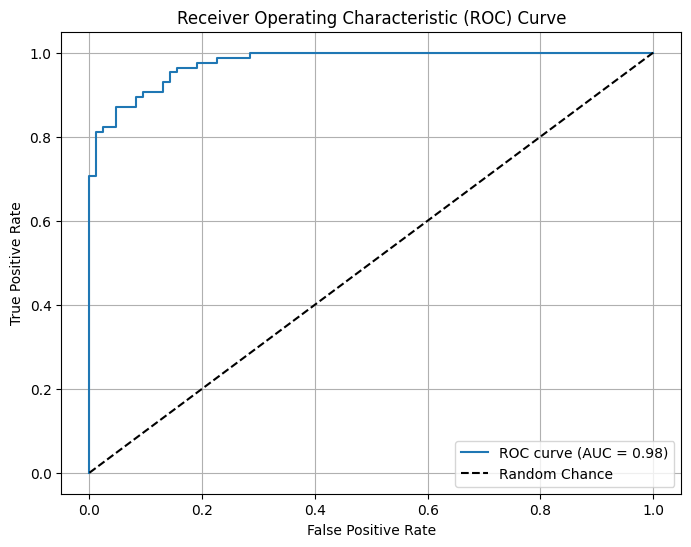

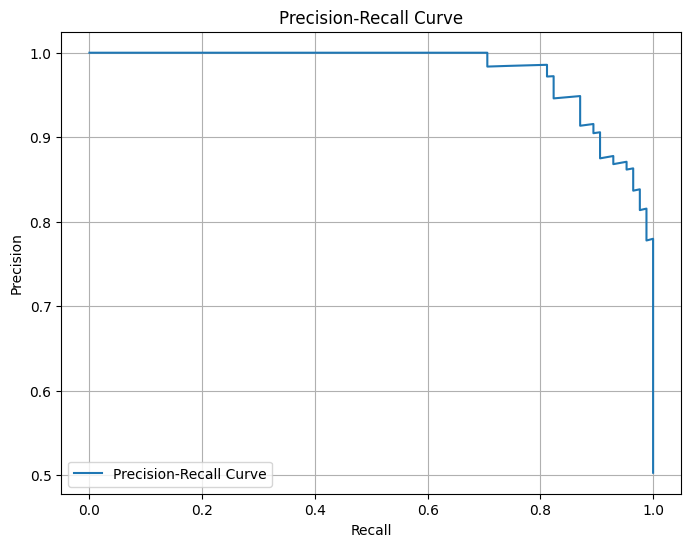

Candidate Thresholds with Recall >= 0.90:
Threshold: 0.00 | Precision: 0.50 | Recall: 1.00 | F1: 0.67 | FP: 84 | FN: 0
Threshold: 0.01 | Precision: 0.65 | Recall: 1.00 | F1: 0.79 | FP: 46 | FN: 0
Threshold: 0.02 | Precision: 0.69 | Recall: 1.00 | F1: 0.82 | FP: 38 | FN: 0
Threshold: 0.03 | Precision: 0.73 | Recall: 1.00 | F1: 0.84 | FP: 32 | FN: 0
Threshold: 0.04 | Precision: 0.76 | Recall: 1.00 | F1: 0.86 | FP: 27 | FN: 0
Threshold: 0.05 | Precision: 0.76 | Recall: 1.00 | F1: 0.86 | FP: 27 | FN: 0
Threshold: 0.06 | Precision: 0.76 | Recall: 1.00 | F1: 0.86 | FP: 27 | FN: 0
Threshold: 0.07 | Precision: 0.77 | Recall: 1.00 | F1: 0.87 | FP: 26 | FN: 0
Threshold: 0.08 | Precision: 0.79 | Recall: 0.99 | F1: 0.88 | FP: 22 | FN: 1
Threshold: 0.09 | Precision: 0.82 | Recall: 0.99 | F1: 0.89 | FP: 19 | FN: 1
Threshold: 0.10 | Precision: 0.83 | Recall: 0.98 | F1: 0.90 | FP: 17 | FN: 2
Threshold: 0.11 | Precision: 0.83 | Recall: 0.98 | F1: 0.90 | FP: 17 | FN: 2
Threshold: 0.12 | Precision: 0.83 

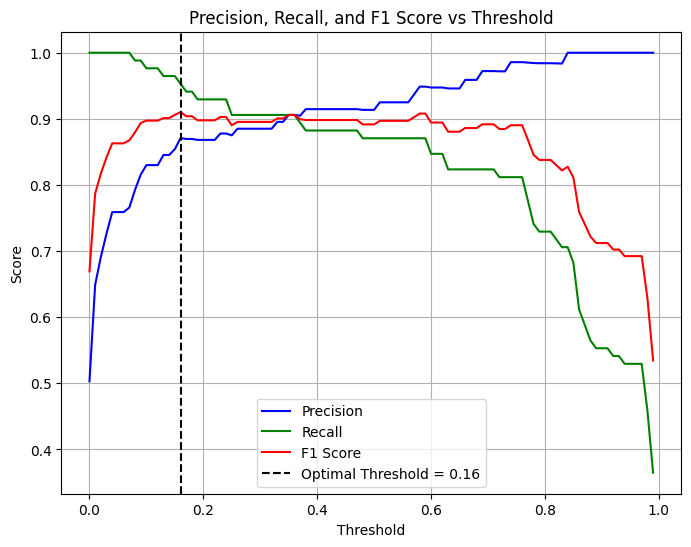

In [ ]:
# Ensure predicted probabilities are in a 1D array
y_true = y_test
y_scores = y_pred.flatten()

# --------------------------
# 1. ROC Curve
# --------------------------
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
auc_value = auc(fpr, tpr)

print("ROC AUC:", auc_value)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --------------------------
# 2. Precision-Recall Curve
# --------------------------
precisions, recalls, pr_thresholds = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# --------------------------
# 3. Grid Search for Optimal Threshold
# --------------------------
# Create an array of candidate thresholds
candidate_thresholds = np.arange(0.0, 1.0, 0.01)
metrics_list = []

# Loop through each candidate threshold to calculate performance metrics
for threshold in candidate_thresholds:
    # Convert probabilities to class predictions based on the current threshold
    y_pred_thresh = (y_scores >= threshold).astype(int)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()

    # Calculate precision, recall, and F1 score
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = f1_score(y_true, y_pred_thresh)

    metrics_list.append({
        'threshold': threshold,
        'precision': precision_val,
        'recall': recall_val,
        'f1': f1,
        'false_positives': fp,
        'false_negatives': fn
    })

# Display metrics for candidate thresholds with high recall (e.g., recall >= 0.90)
target_recall = 0.90
print("Candidate Thresholds with Recall >= 0.90:")
for m in metrics_list:
    if m['recall'] >= target_recall:
        print(f"Threshold: {m['threshold']:.2f} | Precision: {m['precision']:.2f} | Recall: {m['recall']:.2f} | F1: {m['f1']:.2f} | FP: {m['false_positives']} | FN: {m['false_negatives']}")

# Select the optimal threshold.
# For instance, choose the threshold with the highest F1 score among those with recall >= target_recall.
eligible_thresholds = [m for m in metrics_list if m['recall'] >= target_recall]
if eligible_thresholds:
    best_metric = max(eligible_thresholds, key=lambda x: x['f1'])
    optimal_threshold = best_metric['threshold']
    print(f"\nOptimal Threshold Selected: {optimal_threshold:.2f}")
else:
    optimal_threshold = 0.5  # Default threshold if no candidate meets the target recall
    print("\nNo candidate threshold met the target recall. Using default threshold 0.5.")

# Apply the optimal threshold to obtain final class predictions
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Optional: Display confusion matrix for the chosen threshold
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_optimal).ravel()
print("\nConfusion Matrix at Optimal Threshold:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# --------------------------
# Plot Precision, Recall, and F1 scores vs Threshold
# --------------------------
thresholds = [m['threshold'] for m in metrics_list]
precisions = [m['precision'] for m in metrics_list]
recalls = [m['recall'] for m in metrics_list]
f1_scores = [m['f1'] for m in metrics_list]

# Plot Precision, Recall, and F1 scores against Thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')

# Highlight the selected optimal threshold
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()